# Demo of Gated Recurrent Unit

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Cleaning the Data 

In [2]:
# 檢查匯入資料格式
df = pd.read_csv('./df_merged_new.csv')
df['交易年月日_西元'] = df['交易年月日_西元'].astype('datetime64[ns]')
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55642 entries, 0 to 55641
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   建物現況格局-房              55642 non-null  int64         
 1   建物現況格局-廳              55642 non-null  int64         
 2   建物現況格局-衛              55642 non-null  int64         
 3   建物現況格局-隔間             55642 non-null  int64         
 4   有無管理組織                55642 non-null  int64         
 5   單價元平方公尺               55642 non-null  int64         
 6   電梯                    55642 non-null  int64         
 7   預售屋                   55642 non-null  int64         
 8   建築完成距今                55642 non-null  float64       
 9   鄉鎮市區_中山區              55642 non-null  int64         
 10  鄉鎮市區_中正區              55642 non-null  int64         
 11  鄉鎮市區_信義區              55642 non-null  int64         
 12  鄉鎮市區_內湖區              55642 non-null  int64         
 13  鄉鎮市區_北投區        

In [3]:
# 選取相關性前 8 的變數 + 日期
correlation = df.corr()['單價元平方公尺'].sort_values(ascending=False)
correlation

/var/folders/1b/ph7s11556zn5ys84sg42vzpm0000gn/T/ipykernel_13808/3301399123.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['單價元平方公尺'].sort_values(ascending=False)


單價元平方公尺                 1.000000
建物型態_透天厝                0.037719
交易土地                    0.016558
預售屋                     0.012905
鄉鎮市區_大安區                0.012899
電梯                      0.012497
建物型態_住宅大樓(11層含以上有電梯)    0.011580
移轉層次-數字                 0.010460
鄉鎮市區_松山區                0.005983
鄉鎮市區_中正區                0.005592
交易車位                    0.005022
交易距今                    0.004751
鄉鎮市區_中山區                0.004614
鄉鎮市區_北投區                0.003664
交易建物                    0.003580
鄉鎮市區_信義區                0.003214
建物型態_辦公商業大樓             0.002060
建物現況格局-衛                0.001925
建物型態_店面(店鋪)             0.001328
建物現況格局-廳                0.000486
建物型態_套房(1房1廳1衛)        -0.000014
鄉鎮市區_南港區               -0.000081
建物型態_廠辦                -0.001043
鄉鎮市區_大同區               -0.001557
有無管理組織                 -0.002032
建物現況格局-房               -0.003196
路段                     -0.004106
建物型態_華廈(10層含以下有電梯)     -0.004252
鄉鎮市區_內湖區               -0.006450
建物型態_其他                -0.007113
建物現況格局-隔間 

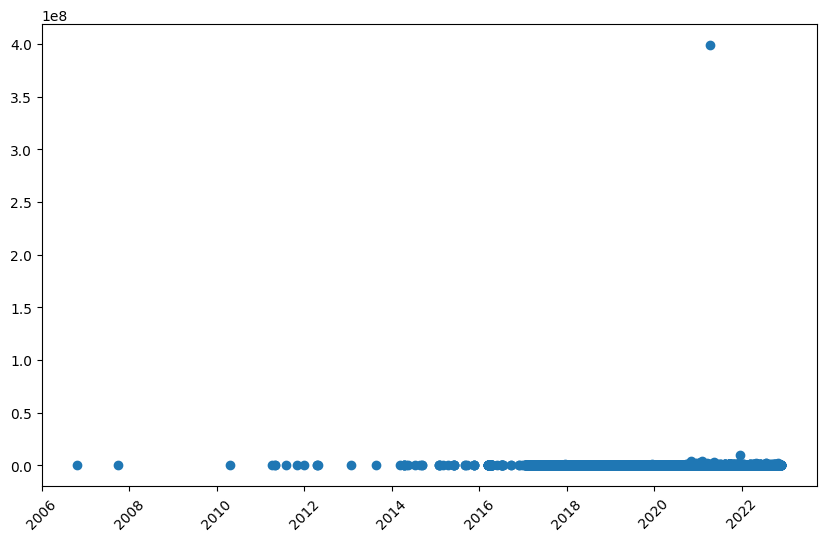

In [4]:
# df 按照 交易年月日_西元 排序
df['交易年月日_西元'] = df['交易年月日_西元'].astype('datetime64[ns]')
df = df.sort_values(by=['交易年月日_西元'])
# 畫圖，x 是交易年月日_西元，y 是單價元平方公尺
plt.figure(figsize=(10, 6))  # 調整圖表大小

plt.scatter(df['交易年月日_西元'], df['單價元平方公尺'])
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動調整x軸刻度的頻率
plt.xticks(rotation=45)  # 調整x軸刻度的旋轉角度
plt.show()

In [5]:


# 將日期特徵轉換為數值特徵
df['交易年月日_西元'] = df['交易年月日_西元'].apply(lambda x: x.toordinal())

# 將目標變量和日期特徵提取出來
features = df.drop(columns=['單價元平方公尺'])
target = df['單價元平方公尺']

# 正規化或標準化特徵
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 將數據分割為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)


In [12]:
# 選擇相關性最高的 8 個欄位
selected_features = ['交易年月日_西元', '建物型態_住宅大樓(11層含以上有電梯)', '移轉層次-數字', '預售屋', '鄉鎮市區_大安區', '電梯', '鄉鎮市區_松山區', '交易車位', '建物型態_透天厝']

# 包括日期，共 9 個特徵
n_features = 9

# 整理資料
data = df[selected_features].values

# 標準化資料
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 使用前 60 天的資料來預測下一天的價格
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, :])
    y.append(scaled_data[i, 0])

# 轉換成 numpy array
X, y = np.array(X), np.array(y)

# 分割資料為訓練集和測試集
split = round(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

# 建立模型
n_neurons = 50
n_outputs = 1

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(60, n_features)))  # 注意這裡的 input_shape 變成了 (60, n_features)

model.add(Dense(n_outputs))

# 編譯模型
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 訓練模型
history = model.fit(X_train, y_train, shuffle = True, epochs=10, batch_size=25, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1779/1779 [==============================] - 14s 7ms/step - loss: 0.0028 - val_loss: 4.4300e-05
Epoch 2/10
1779/1779 [==============================] - 13s 7ms/step - loss: 7.5009e-06 - val_loss: 1.8024e-05
Epoch 3/10
1779/1779 [==============================] - 13s 7ms/step - loss: 5.8445e-06 - val_loss: 4.6784e-06
Epoch 4/10
1779/1779 [==============================] - 13s 7ms/step - loss: 9.0983e-06 - val_loss: 9.4729e-07
Epoch 5/10
1779/1779 [==============================] - 13s 7ms/step - loss: 9.9085e-06 - val_loss: 9.1040e-06
Epoch 6/10
1779/1779 [==============================] - 13s 7ms/step - loss: 5.3563e-06 - val_loss: 1.4514e-06
Epoch 7/10
1779/1779 [==============================] - 13s 7ms/step - loss: 7.7129e-06 - val_loss: 2.9180e-06
Epoch 8/10
1779/1779 [==============================] - 13s 7ms/step - loss: 5.2261e-06 - val_loss: 2.4962e-06
Epoch 9/10
1779/1779 [==============================] - 13s 7ms/step - loss: 4.9885e-06 - val_loss: 4.0729e-07
Epoch

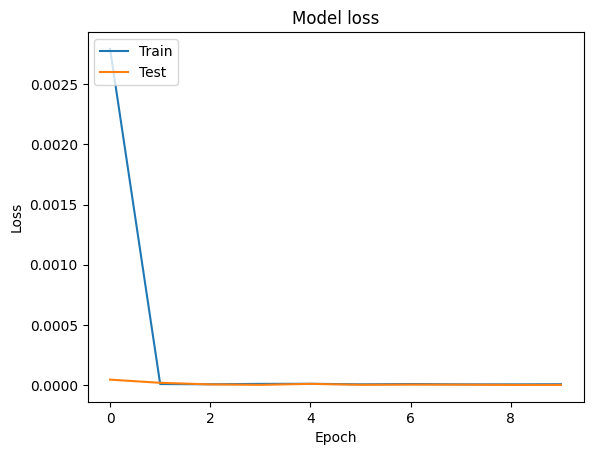

In [13]:
# 繪製訓練 & 驗證的損失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


348/348 [==============================] - 1s 2ms/step


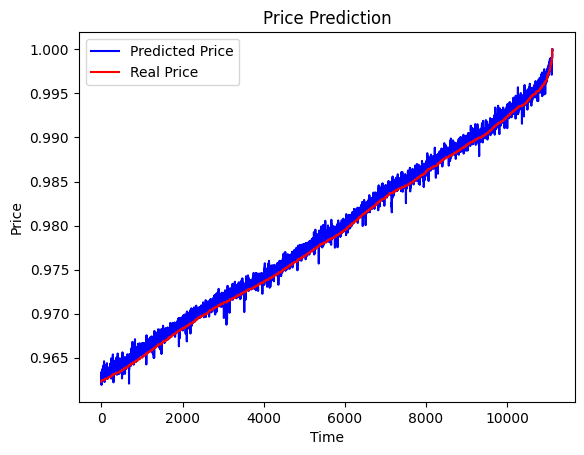

In [14]:
y_pred = model.predict(X_test)
plt.plot(y_pred, color='blue', label='Predicted Price')
plt.plot(y_test, color='red', label='Real Price')

plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [15]:

# 使用模型進行預測
y_test_val = model.predict(X_test)
print(X_train.shape[1])
# 計算MSE
mse = mean_squared_error(y_test, y_test_val)
print("mse:", mse)

# 計算RMSE
rmse = mean_squared_error(y_test, y_test_val, squared=False)
print("rmse:", rmse)

348/348 [==============================] - 1s 2ms/step
60
mse: 4.6359965841320006e-07
rmse: 0.0006808815303804326


In [16]:
model.save('LSTM.h5') #儲存模型

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 成果：預測房價

In [24]:
index = np.random.randint(1, 50000)
selected_features = ['交易年月日_西元', '建物型態_住宅大樓(11層含以上有電梯)', '移轉層次-數字', '預售屋', '鄉鎮市區_大安區', '電梯', '鄉鎮市區_松山區', '交易車位', '建物型態_透天厝']
selected_data = df[selected_features].iloc[index-60:index].values
scaled_data = scaler.transform(selected_data)

new_data = scaled_data.reshape(1, 60, n_features)
model_new = load_model('LSTM.h5')
prediction = model_new.predict(new_data)
print("Prediction:", prediction)

target_scaler = MinMaxScaler()
target_scaler.fit(df[['單價元平方公尺']])  # Replace 'target' with the name of your target variable
scaled_target = target_scaler.transform(df[['單價元平方公尺']])
# Then you can use target_scaler to invert the scale on your model's predictions
original_prediction = target_scaler.inverse_transform(prediction)
print("Original Prediction:", original_prediction)

1/1 [==============================] - 0s 141ms/step
Prediction: [[0.9008527]]
Original Prediction: [[3.59141e+08]]


In [23]:
#用來驗證結果是否不合理
df['單價元平方公尺'].describe()

count    5.564200e+04
mean     2.244830e+05
std      1.693848e+06
min      0.000000e+00
25%      1.541752e+05
50%      2.031890e+05
75%      2.606305e+05
max      3.986678e+08
Name: 單價元平方公尺, dtype: float64